In [66]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import requests
from bs4 import BeautifulSoup
from collections import defaultdict

## emotion detection

In [67]:

base_url = "https://www.business-standard.com/topic/tesla/page-{}"
max_page_limit = 50  # Set your desired page limit

all_data = defaultdict(list)

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}
date_map = {
    'Jan': '01',
    'Feb': '02',
    'Mar': '03',
    'Apr': '04',
    'May': '05',
    'Jun': '06',
    'Jul': '07',
    'Aug': '08',
    'Sep': '09',
    'Oct': '10',
    'Nov': '11',
    'Dec': '12'
}
date_format = '{}-{}-{}'
dates=[]
for page_number in range(1, max_page_limit + 1):
    url = base_url.format(page_number)
    response = requests.get(url, headers=headers)

    if response.status_code != 200:
        print(f"Failed to retrieve page {page_number}. Exiting.")
        break

    soup = BeautifulSoup(response.content, "html.parser")

    # Extract data from the current page
    cardlists = soup.find_all(class_="cardlist")

    for cardlist in cardlists:
        date_tag_info = cardlist.find(class_="meta-info")
        # print(date_tag_info.text)
        data_np = date_tag_info.text.split(' ')
        year_ind=9
        month_ind=7
        date_ind=8
        if len(data_np)<14:
          year_ind-=3
          month_ind-=3
          date_ind-=3

        curr_date = date_format.format(data_np[year_ind], date_map[data_np[month_ind]], data_np[date_ind])
        dates.append(curr_date)
        text_data_tag = cardlist.find("a", class_="smallcard-title")
        text_data = text_data_tag.text
        # print(text_data)
        if text_data and curr_date:
            # Map text-data for each date
            all_data[curr_date].append(text_data)
        if curr_date=='2016-04-03':
          break;

print(dates[-1])


2016-04-03


In [68]:
date_content=[]
for date,text_data_list in all_data.items():
  curr_data=[]
  curr_data.append(date)
  curr_data.append(text_data_list)
  # curr_data_np=np.array(curr_data)
  date_content.append(curr_data)

In [69]:
# reverse the array
date_content = date_content[::-1]

In [70]:
# lower bound func
def lower_bound(date_content, date_given):
    low = 0
    high = len(date_content)-1

    while low < high:
        mid = (low + high) // 2
        if date_content[mid][0] < date_given:
            low = mid + 1
        else:
            high = mid-1

    return low


In [71]:
from datetime import datetime, timedelta

# Define start and end dates
start_date = datetime(2016, 5, 1)
end_date = datetime(2023, 11, 29)

# Define the step size (1 day in this case)
step = timedelta(days=1)

# Traverse through dates
current_date = start_date
date_sentences=[]
while current_date <= end_date:
  if current_date.weekday() != 6 and current_date.weekday() != 5:
    curr=[]
    curr_date_str=current_date.strftime("%Y-%m-%d")
    ind=lower_bound(date_content,curr_date_str)
    count=0
    curr.append(curr_date_str)
    curr_content=""

    while ind>=0 and count<10:
      for content in date_content[ind][1]:
        curr_content+=content+". "
      count+=len(date_content[ind][1])
      ind-=1

    curr.append(curr_content)
    date_sentences.append(curr)
  current_date += step


In [72]:
!pip install vaderSentiment

In [73]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


In [74]:
def sentiment_score(sentence):

    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)
    return sentiment_dict['compound']


In [75]:
date_score=[]
for i in range(len(date_sentences)):
  curr=[]
  curr.append(date_sentences[i][0])
  curr_score=sentiment_score(date_sentences[i][1])
  curr.append(curr_score)
  date_score.append(curr)


## Creating dataset and training with model

In [76]:
def fetch_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Define the stock symbol and date range
ticker_symbol = 'TSLA'
start_date = '2016-05-01'
end_date = '2023-11-29'

In [77]:
# Fetch stock price data
stock_price_data_raw = fetch_stock_data(ticker_symbol, start_date, end_date)
stock_price_data=stock_price_data_raw.drop(['Adj Close'],axis=1)

[*********************100%%**********************]  1 of 1 completed


<Axes: xlabel='Date'>

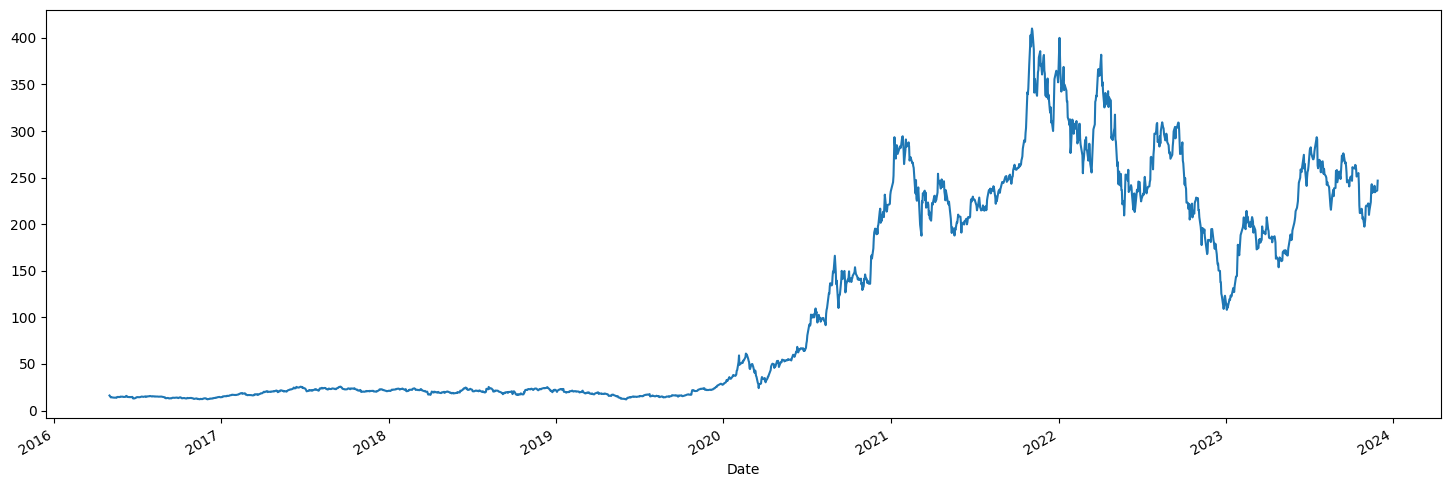

In [78]:
df = stock_price_data_raw['Close']
df.head()
df.plot(figsize=(18,6))

In [79]:

def create_data_set(price_data,time_step):
  dataX,dataY_high,dataY_low=[],[],[]
  for i in range(len(price_data)-time_step-1):
    dataY_high.append(price_data['High'][i+time_step])
    dataY_low.append(price_data['Low'][i+time_step])
    curr_x=[];
    for j in range(i,i+time_step):
      curr_x.append(price_data['Close'][j])
    curr_x.extend([price_data['High'][i+time_step-1],price_data['Low'][i+time_step-1],price_data['Volume'][i+time_step-1]])
    emotion_score=date_score[i][1]
    curr_x.append(emotion_score)
    dataX.append(curr_x)
  return np.array(dataX),np.array(dataY_high),np.array(dataY_low)

In [80]:
X,Y_high,Y_low=create_data_set(stock_price_data,20)

In [81]:
X.shape

(1887, 24)

In [82]:
X.shape

(1887, 24)

In [83]:
Y_high.shape

(1887,)

In [84]:
# Split the data into training and testing sets
X_train_high, X_test_high, Y_train_high, Y_test_high = train_test_split(X, Y_high, test_size=0.1, random_state=42)

In [85]:
def scaling_datapoints(X_toscale):
  # Create a StandardScaler Scaler instance
  scaler = MinMaxScaler()

  X_scaled = scaler.fit_transform(X_toscale)
  return X_scaled


In [86]:
X_train_scaled=scaling_datapoints(X_train_high)
X_test_scaled=scaling_datapoints(X_test_high)

In [87]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM,Dropout


In [88]:
model=Sequential()
model.add(LSTM(64,activation='relu',return_sequences=True,input_shape=(24,1)))
model.add(LSTM(32,activation='relu',return_sequences=False))
# model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [89]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 24, 64)            16896     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29345 (114.63 KB)
Trainable params: 29345 (114.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [90]:
history_high=model.fit(X_train_scaled,Y_train_high,validation_data=(X_test_scaled,Y_test_high),epochs=163,batch_size=64)

Epoch 1/163
27/27 [==============================] - 3s 37ms/step - loss: 27823.3613 - val_loss: 27776.8652
Epoch 2/163
27/27 [==============================] - 1s 25ms/step - loss: 12560.6074 - val_loss: 2152.7927
Epoch 3/163
27/27 [==============================] - 1s 27ms/step - loss: 1557.3085 - val_loss: 887.9935
Epoch 4/163
27/27 [==============================] - 1s 24ms/step - loss: 973.1655 - val_loss: 824.9985
Epoch 5/163
27/27 [==============================] - 1s 19ms/step - loss: 867.9641 - val_loss: 629.7134
Epoch 6/163
27/27 [==============================] - 1s 19ms/step - loss: 751.3383 - val_loss: 799.6063
Epoch 7/163
27/27 [==============================] - 0s 18ms/step - loss: 634.3275 - val_loss: 573.5298
Epoch 8/163
27/27 [==============================] - 0s 18ms/step - loss: 573.2332 - val_loss: 482.3285
Epoch 9/163
27/27 [==============================] - 1s 21ms/step - loss: 581.2178 - val_loss: 481.3922
Epoch 10/163
27/27 [==============================] - 1s

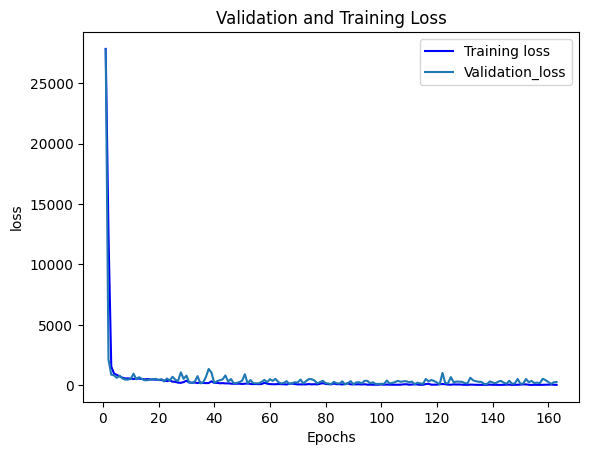

In [91]:
# plots
loss=history_high.history['loss']
val_loss=history_high.history['val_loss']
epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,color='blue',label='Training loss')
plt.plot(epochs,val_loss,label='Validation_loss',)
plt.title("Validation and Training Loss")
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# print(history.history.keys())

In [92]:
# Do the prediction and check performance metrics
train_predict=model.predict(X_train_scaled)
test_predict=model.predict(X_test_scaled)

6/6 [==============================] - 0s 5ms/step


59/59 [==============================] - 0s 5ms/step


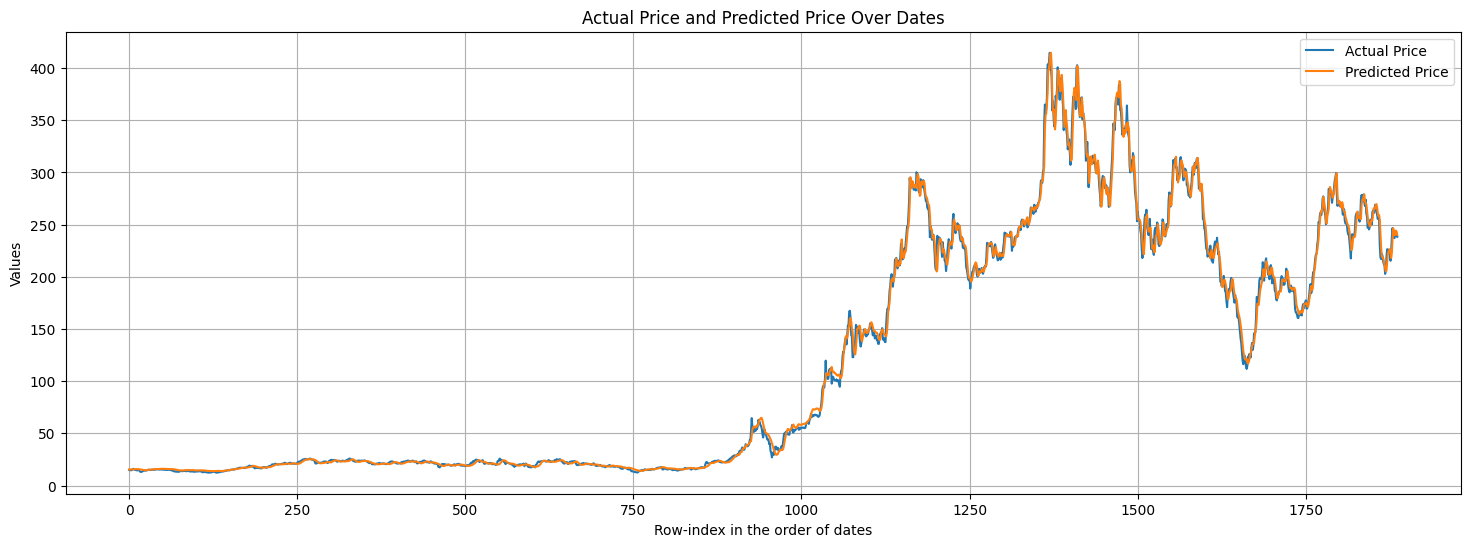

In [99]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import matplotlib.dates as mdates

# Example data
start_date = datetime(2016, 6, 1)  # Replace with your actual start date
date_list = np.arange(0,1887)

actual_price = Y_high  # Replace this with your actual stock price data
X_complete_scaled=scaling_datapoints(X)
predicted_price = model.predict(X_complete_scaled)
predicted_price=predicted_price.reshape(1887)

# Plotting the stock prices
plt.figure(figsize=(18,6))
plt.plot(date_list, actual_price, label='Actual Price')

# Plotting the additional feature
plt.plot(date_list, predicted_price, label='Predicted Price')  # Plot the last day's additional feature as a red dot

# Customize the plot

plt.title('Actual Price and Predicted Price Over Dates')
plt.xlabel('Row-index in the order of dates')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()


## metrics and performance

In [100]:
# Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
mean_squared_error(Y_train_high,train_predict)

31.713552240258363

In [101]:
# Test Data RMSE
mean_squared_error(Y_test_high,test_predict)

279.18031170285195

In [102]:
print(model.predict(X_test_scaled[0:10]).flatten())

1/1 [==============================] - 0s 17ms/step
[304.1543   113.526825 181.22264  268.58243  267.20645  293.25696
  20.028095 323.00006   19.335318  18.485865]


In [103]:
Y_test_high[0:10]

array([272.44332886, 101.15399933, 165.49000549, 259.6000061 ,
       238.75      , 258.36999512,  17.70066643, 295.49334717,
        22.72266769,  19.93333244])

## End